In [1]:
%matplotlib inline
import matplotlib
matplotlib.rc('font', family='arial') 
import matplotlib.pyplot as plt
import numpy as np
from h5py import File
from fish.image.zds import ZDS
from fish.image.vol import InterpArray
import dask.array as da
from dask.distributed import Client

def axs_format(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    

In [2]:
base_dir = '/nrs/ahrens/Yu/SPIM/active_dataset/GliaNeuron/20170221/fish4/20170221_4_3_gfaprgeco_hucgc_6dpf_wholebrain_faster_brighter_20170221_174442_noephys/'
dset = ZDS(base_dir + 'raw/')

NameError: name 'ZDS' is not defined

In [3]:
data = dset.data
exp_name = base_dir.split('/')[-2]
reg_dir = f'/groups/ahrens/ahrenslab/davis/tmp/{exp_name}/'
reg_path = reg_dir + 'regparams_affine.npy'
fs_im = dset.metadata['volume_rate']

NameError: name 'dset' is not defined

In [18]:
window_seconds = 300
window_frames = int(window_seconds * fs_im)
camera_baseline = 80

def mybl(v):
    from fish.image.vol import baseline
    window = window_frames
    percentile = 20
    downsample = 1;
    return baseline((v - camera_baseline).clip(1, None), window, percentile, downsample, axis=0).astype('float32')

def mydff(v):
    from fish.image.vol import dff
    window = window_frames
    percentile = 20
    offset = 10    
    downsample = 1;
    return dff((v - camera_baseline).clip(1, None), window, percentile, offset, downsample, axis=0).astype('float32')

def mydff_dst(v):
    from fish.image.vol import dff
    window = window_frames
    percentile = 20
    offset = 10    
    downsample = 10;
    return dff((v - camera_baseline).clip(1, None), window, percentile, offset, downsample, axis=0).astype('float32')


In [5]:
from fish.util.distributed import get_jobqueue_cluster
cluster = get_jobqueue_cluster()
client = Client(cluster)
client

Client Scheduler: tcp://10.36.111.11:38290 Dashboard: http://10.36.111.11:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [19]:
def get_dff_data(data, roi, baseline_mode):
    from h5py import File
    if baseline_mode == 'ds':
        rechunked = data.rechunk(chunks=(1, 'auto', 'auto', 'auto'))
        
        bl_h5 = da.from_array(File(reg_dir + 'ds_baseline.h5', libver='latest', mode='r')['baseline'], chunks=rechunked.chunksize)
        kf = File(reg_dir + 'ds_baseline.h5', mode='r')['keyframes'][:]
        dsb = InterpArray(x=kf,y=bl_h5, full_shape=data.shape, interpolation_axis=0)
        baseline = dsb[roi]
        return (data / baseline) - 1
    
    if baseline_mode == 'transpose':
        rechunked = data.rechunk(chunks=(data.shape[0], 'auto', 'auto','auto'))
        return rechunked.map_blocks(mydff_dst, dtype='float32')

In [11]:
# make fake data
data_s = da.random.random_integers(80, 200, size=data.shape, chunks=data.chunksize).astype('float32')

In [12]:
cluster.start_workers(40)

In [ ]:
import time
n_reps = 3
roi_t = slice(1000)
rois = (
       (roi_t, slice(None), slice(0,32), slice(None)),
       (roi_t, slice(None), slice(0,64), slice(None)),
       (roi_t, slice(None), slice(0,128), slice(None)),
       (roi_t, slice(None), slice(0,256), slice(None)),
       (roi_t, slice(None), slice(0,512), slice(None)),
       (roi_t, slice(None), slice(0,1024), slice(None)),
       (roi_t, slice(None), slice(0,2048), slice(None)),)

shapes = [data_s[r].shape for r in rois]
shapes_str = [str(x[1:]) for x in shapes]
modes = ['transpose', 'ds']
durations = np.zeros([len(modes), len(rois), n_reps])

dat = data_s

for ind_m, m in enumerate(modes):
    for ind_r, r in enumerate(rois):
        for t in range(n_reps):
            start = time.time()
            get_dff_data(dat[r], r, m)[0].compute()
            elapsed = time.time() - start
            durations[ind_m, ind_r, t] = elapsed
            print(f'{m} : {dat[r].shape} : {t} : {elapsed}')

In [56]:
import xarray as xr

In [60]:
durations.shape

(2, 7, 3)

In [101]:
da = xr.DataArray(durations, coords=[('modes', modes), ('shapes', shapes_str), ('runs', range(durations.shape[-1]))])

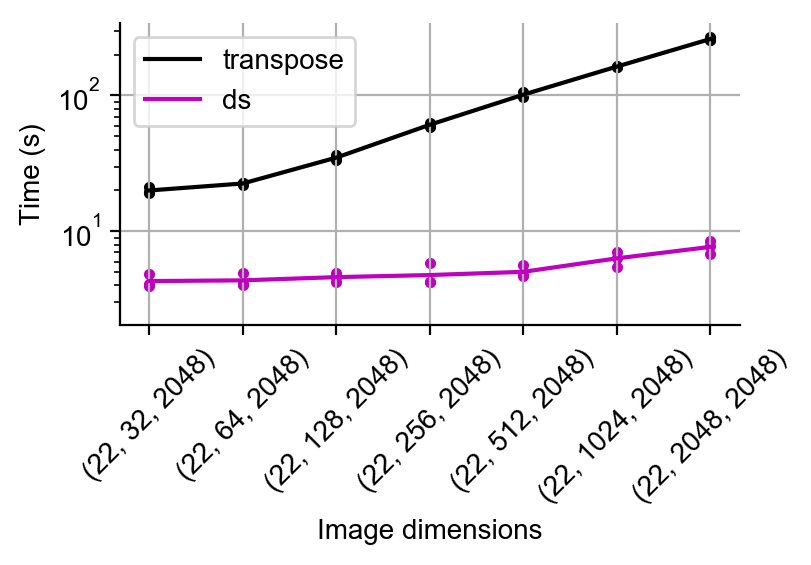

In [44]:
fig, axs = plt.subplots(figsize=(4,2), dpi=200)
axs.grid(True)
for ind, val in enumerate(durations[0]):
    axs.scatter([shapes_str[ind]] * n_reps, val, color='k', marker='.')
    
for ind, val in enumerate(durations[1]):
    axs.scatter([shapes_str[ind]] * n_reps, val, color='m', marker='.')

axs.plot(shapes_str, durations.mean(2)[0],'k', label=modes[0])
axs.plot(shapes_str, durations.mean(2)[1],'m', label=modes[1])
plt.xticks(rotation=45)
axs.set_ylabel('Time (s)')
axs.semilogy()
axs.legend()
axs.set_xlabel('Image dimensions')
axs_format(axs)

plt.savefig('/groups/ahrens/ahrenslab/davis/thesis/baseline_timing.pdf')

In [24]:
cluster.stop_all_jobs()

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
